# **4.1 Keypoint detection and description**

## **Intro**

Cameras provide a huge amount of data to be processed, hence detecting especial features in them is usally mandatory to perform high-level tasks such as image analysis or camera motion estimation.

In general, we can extract different types of elements from the images such as *corners*, *blobs*, *edges*, etc., each of them with different properties, and they are collectively called **image features**. In this chapter we will address one of the most common approaches for extracting information from images, namely **keypoint detection** (i.e. finding *interesting* pixels, or points, in the image).

In this first notebook we will focus on detecting, and describing, *corners*: image points with high variation of intensity in two spatial directions. Concretely, we will cover this:
- Corner detection using the well-known **Harris corner detector** (section 4.1.1).
- Point description and matching using image patches and **Normalized Cross-Correlation** (section 4.1.2).

**This notebook contains <font color=green>2 assignments</font> and <font color=blue>2 sets of questions</font>**

## **Problem context - Image stitching**

Image stitching or photo stitching is the process of combining multiple photographic images with overlapping fields of view to produce a segmented panorama or high-resolution image:

<center>
<img src="https://raw.githubusercontent.com/famoreno/cv_jn_images/master/ch4/insert/stitching.jpg" width="600">
</center>

Feature detection is necessary to find correspondences between images. Robust correspondences are required in order to estimate the necessary transformation to align an image with the image it is being composited on.

Our task in this notebook is to develop the first step in this process. **This lies in developing a robust point matching between overlapping images**.

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (15.0, 15.0)

images_path = '/gdrive/My Drive/Colab Notebooks/Chapter 4. Keypoint detection/images/'

## **Initial data**

Let's start by **displaying our testing image** `car.jpeg` in the RGB color space. This is the image that we are going to use to get familiar with the concepts behind the Harris corner detector. Remember that by default OpenCV reads the image in BGR mode, so we'll have to convert it.

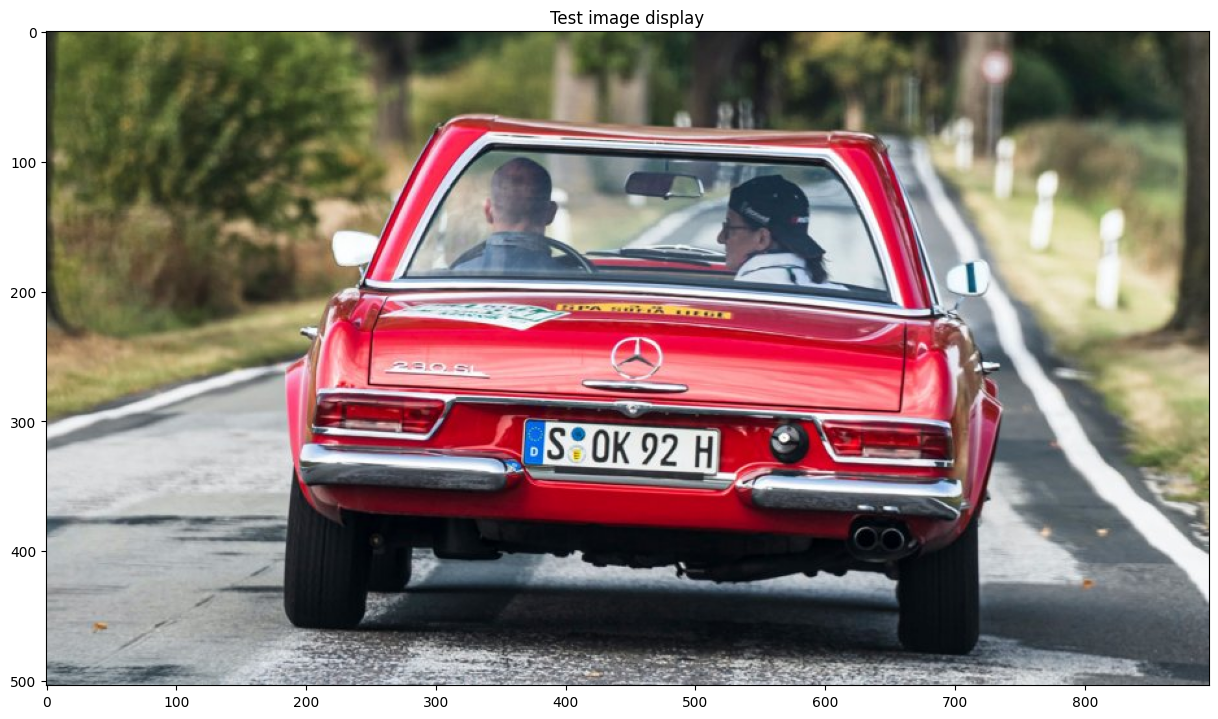

In [3]:
# Read 'car.jpeg' image, convert to RGB and display it
# Read image
img = cv2.imread(images_path + 'car.jpeg')
img1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

# Show it
plt.title('Test image display')
plt.imshow(img1)

## **4.1.1 Harris corner detector**

The **Harris detector** permits us to **detect corners** in an image. It has a number of appealing features:
- **Simple and efficient implementation**.
- **Robustness to noise**, since it considers the application of smoothing techniques.
- It exhibits **invariance to**:
  - **Rotation**: uses eigenvectors.
  - **Brightness** (partially to contrast): uses derivatives.
- Unfortunately **it's not invariant to scale**.

Remember that the Harris detector computes, for each pixel in the image, a certain **response** value $R$ as follows:

$$R = \text{det}(\mathbf{M}) - k (\text{trace}(\mathbf{M}))^2$$

where $k$ is an empirically determined constant value in the range $(0.04-0.06)$, and the matrix $\mathbf{M}$ encompasses the information about how the image intensity spatially changes in a window around such pixel (more information in the course slides!):
$$
\mathbf{M} =
\sum_{x,y} w(x,y)
\begin{bmatrix}
I_x^2 & I_xI_y \\
I_x I_y & I_y^2
\end{bmatrix}
$$

Note that the image derivatives (e.g. Sobel) are involved in the building of $\mathbf{M}$. We have previously used them to detect edges, **and a corner is a point where two edges make contact!**

The $R$ value is interpreted as follows:
- $R$ is large and positive at corners
- $R$ is negative at edges
- $R$ is small at flat regions

The window $w(x,y)$ has another interesting role in the Harris detector: it smooths the computed derivatives, hence providing robustness against image noise. If the window is binary, then it performs average smoothing, and if it is Gaussian, it applies the Gaussian smoothing.



> <font color="orange"> **OpenCV pill** </font>
>
> <font color="orange"> In practice, the Harris detector is already implemented in OpenCV with the method [`cv2.cornerHarris()`](https://docs.opencv.org/2.4/modules/imgproc/doc/feature_detection.html?highlight=cornerharris), which takes as inputs:
>
> - <font color="orange"> **src**: input grayscale image</font>
> - <font color="orange"> **block_size**: neighborhood (window) size</font>
> - <font color="orange"> **ksize**: size of the Sobel kernel (must be an odd value)</font>
> - <font color="orange"> **k**: empiric constant (usually in the range $[0.04,0.06]$)</font>
>
> <font color="orange"> and returns the $R$ value at each pixel.</font>


### **<font color="green">ASSIGNMENT #1a: Response matrix $\mathbf{R}$</font>**

Compute the $\mathbf{R}$ matrix containing the $R$ values for all the pixels in the previous `car.jpeg` image using the Harris detector from OpenCV and display it. Take into account that the **Harris method** (and most keypoint detectors) **works with the grayscale version of the inputs images**. The color image will be used just for visualization purposes.

When you plot the $R$ matrix, also called the *response map*, you should see an image where **borders are black pixels**, **corners are white ones**, and **flat surfaces are gray**.

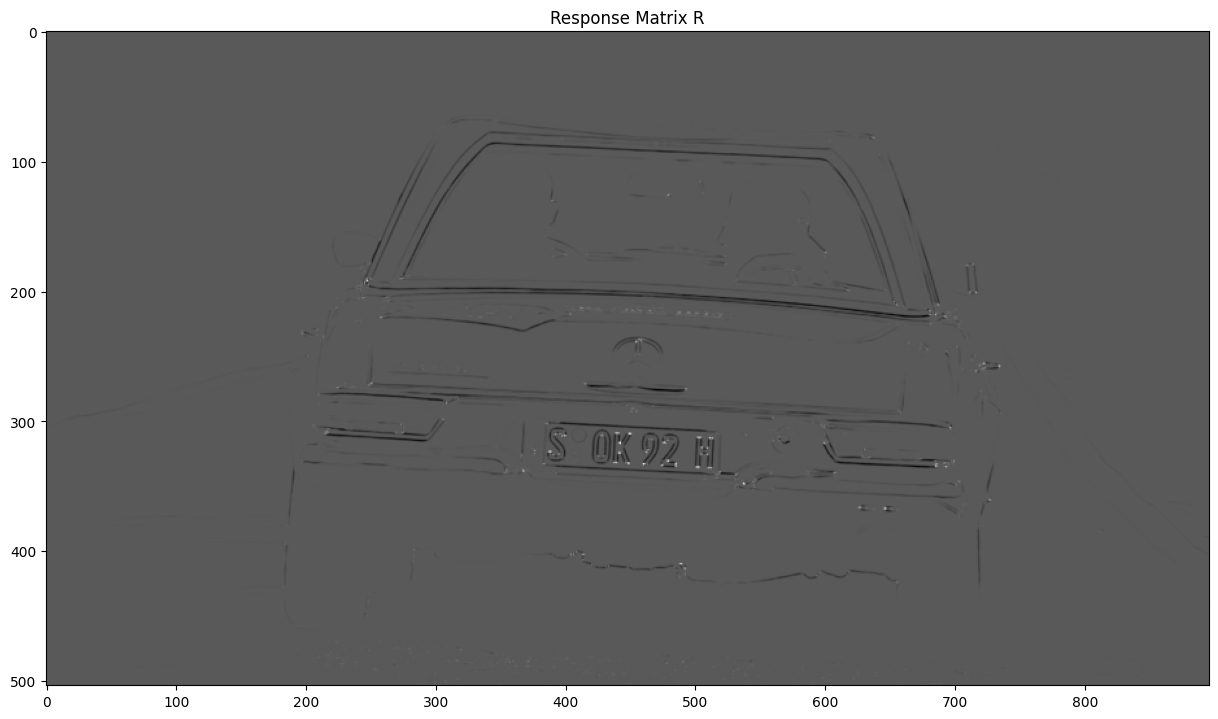

In [4]:
# Assignment #1a
# - Convert the desired image to gray
# - Select the values of the parameters for the cv2.cornerHarris method
# - Call the method
# - Plot the resulting image (that is the R matrix!)


# Write your code here!
gray = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
#gray = np.float32(gray)
R = cv2.cornerHarris(gray,2,3,0.04)
plt.imshow(R, cmap='gray')
plt.title('Response Matrix R')
plt.show()


#### **<font color=red><b>Expected output</b></font>**

<center>
<img src="https://raw.githubusercontent.com/famoreno/cv_jn_images/master/ch4/insert/ch41_a1a_result.png" width="450">
</center>

#### <font color="blue"><b>Discussion #1</b></font>

**It is interesting** to play a bit with the input parameters. Then **answer the following questions**:

- What happens if the size of $w(x,y)$ is 1?
  
    <font color=blue><b>The derivatives result in the identification of flat surfaces as corners, due to the absence of any smoothing or noise elimination processes.</b></font>
    
- What happens if the size of $w(x,y)$ is large? (*note that `cv2.cornerHarris()` uses neighborhood averaging instead of Gaussian filtering*)
  
    <font color=blue><b>
We get excessive blurring of the image makes it challenging to accurately acquire and visualize the corners.</b></font>

### **<font color="green">ASSIGNMENT #1b: Thresholding $\mathbf{R}$</font>**

The previous code computes the response map $\mathbf{R}$ but, in the end, we need information about which pixels are corners, that is, a binary YES/NO response. This is typically done by setting a **threshold** so pixels with a response higher than it are considered corners.

In order to make an informed choice of that threshold, first, print the maximum and minimum values in the response map $\mathbf{R}$.

> <font color="orange"> Use the `max()` and `min()` methods applied to the response matrix (numpy matrix) to get them.</font>

These extrema values are different for different images and/or input parameters. Thus, it is necessary to define the threshold **relative to the maximum value** in $\mathbf{R}$ (in this way we skip normalization). Use the OpenCV's [`cv2.threshold()`](https://docs.opencv.org/trunk/d7/d1b/group__imgproc__misc.html#gae8a4a146d1ca78c626a53577199e9c57) method to binarize the $\mathbf{R}$ matrix using a threshold that you think is suitable (**proportional to the maximum value**). Then, display the binarized image.

max value of the obtained R matrix:  0.022888549 
 min value of the obtained R matrix:  -0.012324028


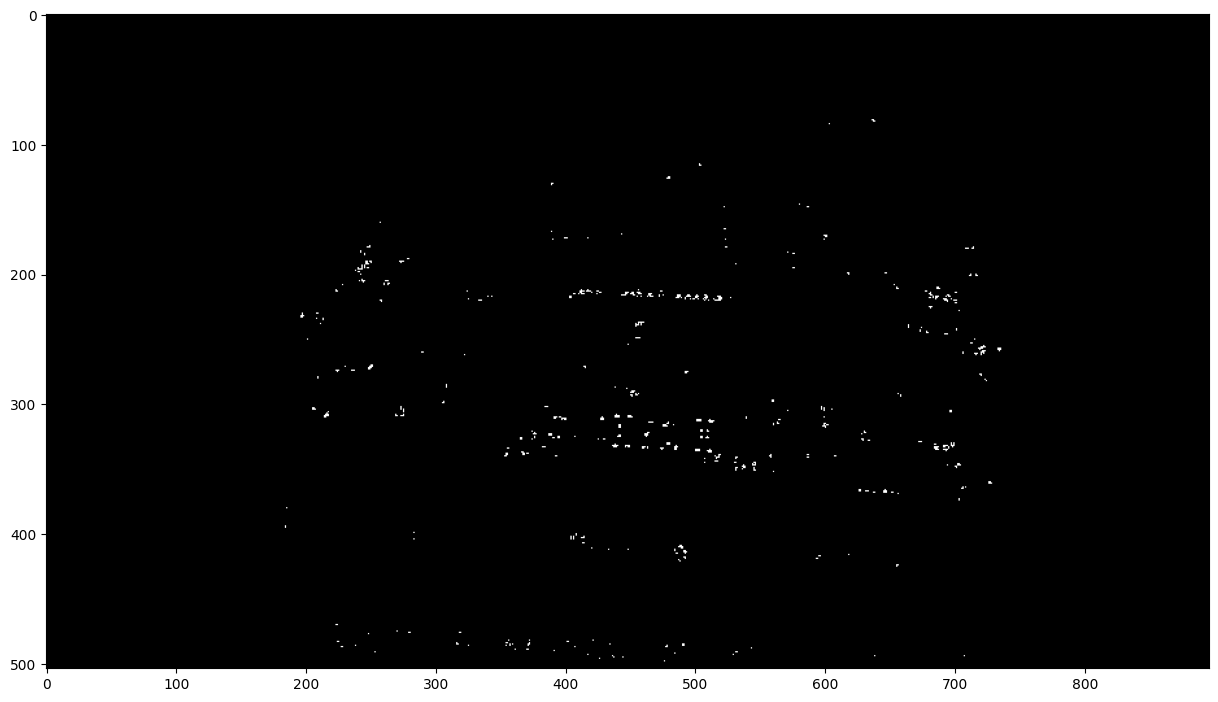

In [5]:
# Assignment #1b
# - Print 'max' and 'min' values of the obtained R matrix
# - Define the threshold wrt the maximum value
# - Apply binarization and show the result

# Write your code here!
print("max value of the obtained R matrix: " , R.max(), "\n min value of the obtained R matrix: ", R.min())
threshold = 0.04*R.max()
threshold_m, bin = cv2.threshold(R,threshold, 255,cv2.THRESH_BINARY)
plt.imshow(bin, cmap='gray')

#### **<font color=red><b>Expected output</b></font>**

<center>
<img src="https://raw.githubusercontent.com/famoreno/cv_jn_images/master/ch4/insert/ch41_a1b_result.png" width="700">
</center>

### **<font color="green">ASSIGNMENT #1c: Non-maxima suppression</font>**

Note that the resulting binarized image shows clusters of white points that represent near pixels above the threshold (we are getting multiple responses for the same corner).

The general solution to this is to apply what is called **non-maximum suppression** to those clusters of points, keeping only a point for each of them (remember that this step was also part of the Canny edge detector!).$\\[10pt]$

<center>
<img src="https://raw.githubusercontent.com/famoreno/cv_jn_images/master/ch4/insert/nonmax.png" width="600">$\\[5pt]$
</center>

To make this easier for you, we provide a `nonmaxsuppts()` function with an implementation of the non-maximum suppression step, which finds local maxima within a window. This method returns a list of `cv2.Keypoints` with the isolated corners.

In [6]:
# This method has been provided to you
from scipy import signal
def nonmaxsuppts(cim, radius, thresh):
    """ Binarize and apply non-maximum suppresion.

        Args:
            cim: the harris 'R' image
            radius: the aperture size of local maxima window
            thresh: the threshold value for binarization

        Returns:
            r, c: two numpy vectors being the row (r) and the column (c) of each keypoint
    """

    rows, cols = np.shape(cim)
    size = 2 * radius + 1
    mx = signal.order_filter(cim, np.ones([size, size]), size ** 2 - 1)
    bordermask = np.zeros([rows, cols]);
    bordermask[radius:(rows - radius), radius:(cols - radius)] = 1
    cim = np.array(cim)
    r, c = np.where((cim == mx) & (cim > thresh) & (bordermask == 1)) # row and cols
    kps = [cv2.KeyPoint(np.float32(c[i]), np.float32(r[i]), 2) for i in range(len(r))]        # keypoint list

    #return kps
    return r, c

> <font color="orange"> In order to represent keypoints, OpenCV defines a set of functions for drawing objects related to feature detection. An example is [cv2.drawKeypoints](https://docs.opencv.org/4.x/d4/d5d/group__features2d__draw.html#gab958f8900dd10f14316521c149a60433), which given an image and a list of [cv2.KeyPoint](https://docs.opencv.org/4.x/d2/d29/classcv_1_1KeyPoint.html) objects, it draws them on the output image (third input argument). Note that this implies the transformation of `r` and `c` to a `cv2.KeyPoint` list, as you can see in the method provided above. Have a look at: [rows and columns to KeyPoint list ideas](https://www.programcreek.com/python/example/77058/cv2.KeyPoint).</font>

Now, apply non-maxima suppression to the previous $\mathbf{R}$ image and draw the detected keypoints on the image.

In [7]:
# Asignment #1c
# - Define the radius of the keypoint neighborhood to be considered and a proper threshold
# - Apply non-max suppression to R
# - Display the remaining keypoints on the image

# Write your code here!
[r,c] = nonmaxsuppts(dst,5,threshold)
kps = []
image_kps = image1.copy()
cv2.drawKeypoints(image1,kps,image_kps)
plt.imshow(image_kps)


NameError: ignored

#### **<font color=red><b>Expected output</b></font>**

<center>
<img src="https://raw.githubusercontent.com/famoreno/cv_jn_images/master/ch4/insert/ch41_a1c_result.png" width="700">
</center>

## **4.1.2 Keypoint matching with NCC**

Note that we have just **detected** the corners, that is, locate their positions in the image. This might be enough for some applications but, in general, we also need to **describe** the keypoints. This description will help us to find the same keypoint in different images.

The simplest descriptor for a keypoint is extracting **a patch of the image** with the keypoint at its center. But, how to match keypoints according to these patches? Computing the **Normalized Cross-Correlation (NCC)** between the patches is one of the ways.

NCC has these properties:
- It is applied through convolution.
- It is invariant to changes in brightness and contrast.
- It ranges from -1 to +1, the closer to +1 the more similar the patches are.

Let's work with it.

> <font color="orange"> OpenCV implements the function [`cv2.matchTemplate()`](https://docs.opencv.org/2.4/modules/imgproc/doc/object_detection.html?highlight=matchtemplate), which takes as first argument an `image`, and applies NCC with the `template` or patch provided as second argument (as set by its third argument: `cv2.TM_CCORR_NORMED`). That is, the template slides over every pixel in the image and its NCC response is computed, giving a score indicating how much the template looks like the image at that pixel. </font>

> <font color="orange"> This code will help you to understand how NCC works.   
- **Review it and try to explain what is done here** (you can modify `p_index` and `w_temp` parameters). </font>

In [ ]:
# This snippet has been provided to you. Play with 'p_index' and 'w_temp' values

# Index of the focusing point
p_index = 26

# NCC window aperture
w_temp = 20

# Get the NCC window
p_x, p_y = r[p_index], c[p_index]
template = img[p_y-w_temp:p_y+w_temp+1,p_x-w_temp:p_x+w_temp+1]

# Calculate the NCC image (note the cv2.TM_CCORR_NORMED parameter!)
ncc = cv2.matchTemplate(img, template, cv2.TM_CCORR_NORMED)

# Search the maximum in NCC
[max_y, max_x] = np.where(ncc == np.amax(ncc))
max_x = int(max_x)
max_y = int(max_y)

# Draw a rectangle in matching points in the color image and the NCC one
image_draw = np.copy(img)
ncc_draw = np.copy(ncc)

cv2.rectangle(image_draw,(p_x-w_temp,p_y-w_temp),(p_x+w_temp+1,p_y+w_temp+1),(0,255,0),3)
cv2.rectangle(ncc_draw,(max_x-w_temp,max_y-w_temp),(max_x+w_temp+1,max_y+w_temp+1),0,3)

# Show the original image
plt.subplot(121)
plt.imshow(image_draw)
plt.title('Original image')

# Show the NCC image
plt.subplot(122)
plt.imshow(ncc_draw, cmap='gray')
plt.title('NCC')
plt.show()

As you can see, the patch with the green rectangle in the left image has a maximum NCC value at the black rectangle in the right image. As you can imagine, since the template is extracted from the same image, the NCC value will be 1 at the same exact position (the template and the image at that point are exactly the same!). But this is just an example to illustrate how all this works.

### <font color="blue"><b>Discussion #2</b></font>

Now, **answer the following questions**:

- Describe what variables `p_index` and `w_temp` do.
  
  <font color=blue><b>The variable "p_index" denotes the specific keypoint that we will be focusing on. In our scenario, we have selected column 26 and row 26 as the target coordinates.
  The variable "w_temp" represents the width of the window applied to the keypoint. This window is then compared with various locations within the image.
  </b></font>    

- What does the NCC image/response represent?
  
  <font color=blue><b>The NCC image represents the similarity or match between the window, centered around the selected keypoint, and different regions of the image. It quantifies the degree of similarity between the window and each region, producing a correlation value for each pixel or location in the image. The NCC image is generated by applying normalized cross-correlation using the window of size "w_temp" around the selected keypoint at "p_index". </b></font>    

- What would happen if `template` was taken from a similar (but not the same) image?
  
  <font color=blue><b>If the template is taken from a similar but not the same image, the matching results may be partial, distorted, without a matching point in the image or produce false positives. There is a higher chance of inaccurate matches and missed detections due to differences between the template and the target image.</b></font>    

Finally we are going to compute matches between two images with overlapping areas. The images are `park_l.jpeg` (left) and `park_r.jpeg` (right).

**For that, you should use the Harris corner detector and the NCC descriptor**. Then, you will draw the keypoints and the matches using the OpenCV's method [`cv2.drawMatches()`](https://docs.opencv.org/3.4/d4/d5d/group__features2d__draw.html#ga7421b3941617d7267e3f2311582f49e1). It takes as inputs:
- The two images.
- The two lists of `cv2.KeyPoint` objects obtained with Harris (one for each image).
- A list of [`cv2.DMatch`](https://docs.opencv.org/3.4/d4/de0/classcv_1_1DMatch.html) objects with the matches. Each `cv2.DMatch` is created with `cv2.DMatch(idx_l, idx_r,1)`, being `idx_l` and `idx_r` the indices of the matching keypoints in the left and right lists of keypoints, respectively (e.g. `cv2.DMatch(9, 4, 1)` means the $9$-th keypoint in the left image and the $4$-th keypoint in the right one).

> <font color="orange"> Tip: [Drawing functions documentation](https://docs.opencv.org/master/d4/d5d/group__features2d__draw.html).</font>


### **<font color=green>ASSIGNMENT #2a: First, detect keypoints with Harris</font>**

- Use the Harris corner detector to get the keypoints of `park_l.jpeg` and `park_r.jpeg` images in grayscale (do not forget to apply non-max suppression to the resulting $\mathbf{R}$ image!).

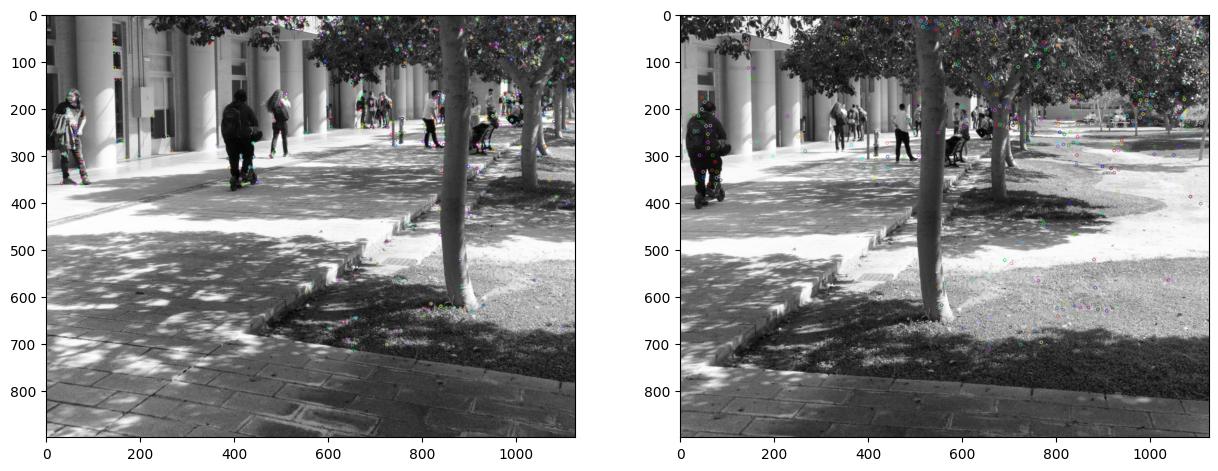

In [8]:
# Assignment #2a
# - Detect Harris keypoints in the (grayscale) images
# - Apply non-maxima suppresion and get two lists of keypoints

# Write your code here!
park_l = cv2.imread(images_path + 'park_l.jpeg')
park_l_g = cv2.cvtColor(park_l, cv2.COLOR_BGR2GRAY)
R_l = cv2.cornerHarris(park_l_g, 5, 3, 0.05)
t_l = 0.05*R_l.max()
[r_l,c_l] = nonmaxsuppts(R_l,5,t_l)
kps_l = []
kps_img_l = park_l.copy()

for i in range(np.size(r_l)):
  kps_l.append(cv2.KeyPoint(int(c_l[i]),int(r_l[i]),1))

#SEGUNDA IMGAEN
park_r = cv2.imread(images_path + 'park_r.jpeg')
park_r_g = cv2.cvtColor(park_r, cv2.COLOR_BGR2GRAY)

R_r = cv2.cornerHarris(park_l_g,5,3,0.05)

t_r = 0.05*R_r.max()
[r_r,c_r] = nonmaxsuppts(R_r,5,t_r)

kps_r = []
kps_img_r = park_r_g.copy()

for i in range(np.size(r_r)):
  kps_r.append(cv2.KeyPoint(int(c_r[i]),int(r_r[i]),1))

#Graficar
plt.subplot(1,2,1)
kps_img_l = cv2.drawKeypoints(park_l_g,kps_l,np.array([]))
plt.imshow(kps_img_l, cmap='gray')

plt.subplot(1,2,2)
kps_image_r = cv2.drawKeypoints(park_r_g,kps_r,np.array([]))
plt.imshow(kps_image_r, cmap='gray')
plt.show()

### **<font color="green">ASSIGNMENT #2b: Avoiding issues</font>**

Now, we will address an intermediate step to avoid future issues. As we will need to extract a template around the keypoints and it might happen that those can be detected too close to the border (e.g. a keypoint found at (0,0)), we will add a *padding* to the image using the OpenCV's method
[`cv2.copyMakeBorder()`](https://docs.opencv.org/2.4/modules/imgproc/doc/filtering.html?highlight=copymakeborder#void%20copyMakeBorder(InputArray%20src,%20OutputArray%20dst,%20int%20top,%20int%20bottom,%20int%20left,%20int%20right,%20int%20borderType,%20const%20Scalar&%20value)) (`cv2.BORDER_REFLECT` is the best padding option in this case). Read the documentation and guess the best values for the parameters.

In [9]:
# Assignment 2b
# Add padding to the images

# Write your code here!



lados= 20
img_borderl = cv2.copyMakeBorder(kps_img_l,lados,lados,lados,lados,cv2.BORDER_REFLECT)
img_borderr = cv2.copyMakeBorder(kps_img_r,lados,lados,lados,lados,cv2.BORDER_REFLECT)


### **<font color="green">ASSIGNMENT #2c: Matching</font>**

And finally:
- For every $i$-th keypoint in the **left image**:
    - Extract a patch around that point (remember slicering a matrix in numpy).
    - Compute the NCC value using that template with **the whole right image**, as in the provided example.
    - Since we want to retrieve true matches, find **the maximum NCC value obtained at the positions of the keypoints** in the right image.
    - If the maximum NCC value (for a $j$ keypoint in the right image) is greater than a certain threshold (e.g. 0.95, but tune it for robustness), create a `cv2.DMatch` object with the indexes $(i,j)$ of the keypoints and add it to a list of matches.
- Once all matches are defined, use the `cv2.drawMatches()` method to display the resulting color image with the matches.

Be careful with the number of keypoints detected, as **it could take some time to process all of them!**

> <font color="orange"> Tip: When displaying the resulting image, it is preferable to make a copy of the original color image and use it as the output image for the `cv2.drawMatches()` method. This way it keeps the same size as the original one.</font>

In [11]:
# Assignment 2c
# Match the keypoints in both images by using NCC, get a 'cv2.DMatch' list and display the matches
# - Create an empty list for matches
# - For each keypoint in left image:
# -- Get the patch around it (note the 'w_temp' offset because of the padding in previous step)
# -- Compute NCC of the left keypoint in the whole right image
# -- Find the max value in NCC but only at positions of the keypoints in the right image
# -- If the max value is over a threshold, then the match is good -> add it to the list of matches
# - Finally, draw the obtained matches

# Write your code here!
w_temp = 20
matches=[]
for i in range(len(kps_l)):
    template = img_borderl[r_l[i]-w_temp+w_temp:r_l[i]+w_temp, c_l[i]-w_temp+w_temp:c_l[i]+w_temp]
    ncc = cv2.matchTemplate(img_borderr, template, cv2.TM_CCORR_NORMED)

    if np.amax(ncc) > 0.95:
        kp_match = np.where(ncc == np.amax(ncc))
        kp_match = cv2.KeyPoint(float(kp_match[1]),float(kp_match[0]),1)

        for j in range(len(kps_r)):
            if(kp_match.pt == kps_r[j].pt):
                matches.append(cv2.DMatch(i,j,1))

dimg = np.copy(img_borderl)
dimg = cv2.drawMatches(img_borderl, kps_l, img_borderr, kps_r, matches, dimg,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(dimg, cmap='gray')

error: ignored

#### **<font color=red><b>Expected output</b></font>**

<center>
<img src="https://raw.githubusercontent.com/famoreno/cv_jn_images/master/ch4/insert/ch41_a2c_result.png" width="1000">

Output of [`cv2.drawMatches()`](https://docs.opencv.org/3.4/d4/d5d/group__features2d__draw.html#ga7421b3941617d7267e3f2311582f49e1))
</center>

Great! You have been able to find keypoints in two images and match them! You would probably have found that **not all matches are correct**, and that is normal (they are called **outliers**, or false positives). Take into account that matching keypoints based on their appearance around a small patch is not really easy for computers (not even for humans!). Of course, there are other methods to describe the keypoints that are more robust, as we will see next.

In real applications, this "outliers" problem is addressed by implementing certain filters that incorporate more information about the scene.

## **Conclusion**

This was a hard work, but finally you made it! In this notebook you have learned to:

- detect corners using the Harris detector,
- match corners using image patches and NCC, and
- develop the first steps for an image stitching system.